# MODULE 3
## Milestone 1: exploration phase

In [59]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from typing import Tuple
from sklearn import linear_model
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

plt.style.use("ggplot")

In [4]:
box_builder_sample_data = '/home/unai/datasets/feature_frame.csv'
bb_df = pd.read_csv(box_builder_sample_data)
bb_df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [5]:
bb_df.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')

In [6]:
bb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [7]:
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col = 'outcome'
features_cols = [col for col in bb_df.columns if col not in info_cols + [label_col]]

categorical_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = [col for col in features_cols if col not in categorical_cols + binary_cols]

In [8]:
bb_df[categorical_cols].describe()

,product_type,vendor
count,2880549,2880549
unique,62,264
top,tinspackagedfoods,biona
freq,226474,146828


##### Categorical variables have very high cardinality. We are goning to use frequency encoding.

In [9]:
# Frequency encoder
def calculate_frequency(categorical_data):
    result = pd.DataFrame()
    for column in categorical_data.columns:
        counts = dict(categorical_data[column].value_counts() / len(categorical_data))
        result[column] = categorical_data[column].map(counts)
    return result

# Create FunctionTransformer to apply the frequency encoder
frequency_encoder = FunctionTransformer(func=calculate_frequency, validate=False)

In [10]:
# We only keep orders with at least 5 items
orders = bb_df['order_id'].unique()
orders_more5 = orders[bb_df.groupby('order_id')['outcome'].sum() >= 5]
bb_df = bb_df.loc[bb_df['order_id'].isin(orders_more5)]

In [11]:
bb_df[label_col].value_counts()/len(bb_df)*100

outcome
0.0    98.552233
1.0     1.447767
Name: count, dtype: float64

##### Unbalanced problem --> We must mantain the porcentage in train, validation and testing datasets

In [12]:
# We avoid information leakage in train and test datasets of different users
users = bb_df['user_id'].unique()
users_train, users_validation, users_test = np.split(users, [int(.6 * len(users)), int(.78 * len(users))])

In [13]:
train = bb_df[bb_df['user_id'].isin(users_train)].reset_index()
X_train = train[features_cols]
Y_train = train[label_col]

validation = bb_df[bb_df['user_id'].isin(users_validation)].reset_index()
X_validation = validation[features_cols]
Y_validation = validation[label_col]

test = bb_df[bb_df['user_id'].isin(users_test)].reset_index()
X_test = test[features_cols]
Y_test = test[label_col]

In [14]:
print(f"Value counts train: {(Y_train.value_counts()/len(Y_train)*100).to_dict()}")
print(f"Value counts validation: {(Y_validation.value_counts()/len(Y_validation)*100).to_dict()}")
print(f"Value counts test: {(Y_test.value_counts()/len(Y_test)*100).to_dict()}")

Value counts train: {0.0: 98.48475974586931, 1.0: 1.5152402541306886}
Value counts validation: {0.0: 98.674001140962, 1.0: 1.3259988590379859}
Value counts test: {0.0: 98.73850229644577, 1.0: 1.2614977035542296}


##### We keep the balance in the training, validation and testing datasets

## TESTING DIFFERENT MODELS

### LOGISTIC REGRESSION

In [15]:
train_columns = numerical_cols + binary_cols + categorical_cols
preprocessor = ColumnTransformer(
    [
        ('numerical', 'passthrough', numerical_cols),
        ('binary', 'passthrough', binary_cols),
        ('categorical', frequency_encoder, categorical_cols), # Also with CountEncoder library
    ]
)

linear_reg =  Pipeline([('Freq_Encoding', preprocessor), ('Scaler', StandardScaler()), ('regr', linear_model.LogisticRegression(penalty=None, max_iter=250, solver='lbfgs'))])
linear_reg.fit(X_train[train_columns], Y_train)        

Pipeline(steps=[('Freq_Encoding',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['user_order_seq',
                                                   'normalised_price',
                                                   'discount_pct',
                                                   'global_popularity',
                                                   'count_adults',
                                                   'count_children',
                                                   'count_babies', 'count_pets',
                                                   'people_ex_baby',
                                                   'days_since_purchase_variant_id',
                                                   'avg_days_to_buy_variant_id',
                                                   'std_days_to_buy_variant_id',
                                                   'days_since_purcha...
                                                   'avg_days_to_buy_product_type',
                                                   'std_days_to_buy_product_type']),
                                                 ('binary', 'passthrough',
                                                  ['ordered_before',
                                                   'abandoned_before',
                                                   'active_snoozed',
                                                   'set_as_regular']),
                                                 ('categorical',
                                                  FunctionTransformer(func=<function calculate_frequency at 0x7f93ca14ccc0>),
                                                  ['product_type',
                                                   'vendor'])])),
                ('Scaler', StandardScaler()),
                ('regr', LogisticRegression(max_iter=250, penalty=None))])

In [16]:
betas_lr = np.array(linear_reg.named_steps['regr'].coef_[0])

In [17]:
def plot_betas(model:str, columns:np.array, betas:np.array, figure:Tuple[matplotlib.figure.Figure, np.array]=None):
    if figure is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    else:
        fig, ax = figure

    ax.barh(columns, betas, label=f'{model}')
    ax.set_xlabel('Coeficiente')
    ax.set_ylabel('Variable')
    ax.set_title(f'Coeficientes de las variables')
    ax.legend()
    ax.grid(axis='x', linestyle='--', alpha=0.6)

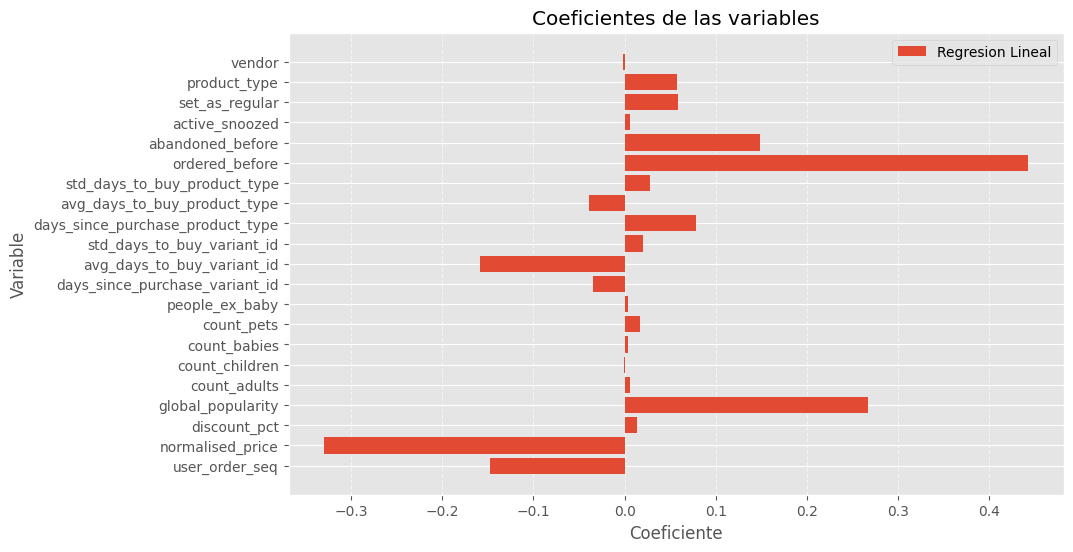

In [18]:
plot_betas(model='Regresion Lineal', columns=train_columns, betas = betas_lr)

### Dado que no hay diferencias de escalas considerables en las variables, en esta gráfica se puede observar la relevancia de cada una de las variables a la hora de predecir los resultados. Las variables más importantes son:
- Abandoned_before: Lógico porque si ese producto ha sido abandonado por el usuario, e sun factor que puede influir a la hora de comprarlo o no después.
- Ordered_before: Pasa lo mismo que con la anterior. Si ha sido comprado el item anteriormente, hay posibilidades de que lo vuelva a comprar.
- Normalised_price: El precio del producto es un factor importante a la hora de comprarlo o no. A mayor precio, menos probabilidad de compra. Por eso la relación es negativa.
- User_order_seq: Esta relacion negativa indica en los datos que cuantos menos pedidos haya hecho anteriormente el usuario, menor probabilidad de compra tiene
- Global_popularity: Un producto popular tiene más tendencia a ser comprado.

In [19]:
Y_prob_lr = linear_reg.predict_proba(X_validation)[:,1]

In [20]:
def calculate_metrics(y_prob:pd.Series, y_true:pd.Series) -> Tuple[pd.DataFrame, np.float64, pd.DataFrame, np.float64]:
    #ROC
    fpr, tpr, thresholds_roc = metrics.roc_curve(y_true, y_prob)
    auc_roc = round(metrics.roc_auc_score(y_true, y_prob), 4)
    roc = pd.DataFrame({'TPR': tpr, 'FPR': fpr, 'Threshold': thresholds_roc})

    #Precision-Recall
    precision, recall, thresholds_precrec = metrics.precision_recall_curve(y_true, y_prob)
    auc_precrec = round(metrics.auc(recall, precision), 4)
    precision_recall = pd.DataFrame({'Precision': precision[:len(precision) - 1], 'Recall': recall[:len(recall) - 1], 'Threshold': thresholds_precrec})

    return (roc, auc_roc, precision_recall, auc_precrec)

In [21]:
def plot_metrics(model:str, roc:pd.DataFrame, auc_roc:np.float64, prec_rec:pd.DataFrame, auc_precrec:np.float64, figure:Tuple[matplotlib.figure.Figure, np.array]=None):
    #Plot
    if figure is None:
        fig, ax = plt.subplots(1,2, figsize=(14,7))
    else:
        fig, ax = figure

    ax[0].plot(roc['FPR'],roc['TPR'],label=f"{model}; AUC="+str(auc_roc))
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].legend()
    ax[0].set_title("Validation ROC curve")  

    ax[1].plot(prec_rec['Recall'], prec_rec['Precision'],label=f"{model}; AUC="+str(auc_precrec))
    ax[1].set_ylabel("Precision")
    ax[1].set_xlabel("Recall")
    ax[1].legend()
    ax[1].set_title("Validation Precision-Recall curve") 


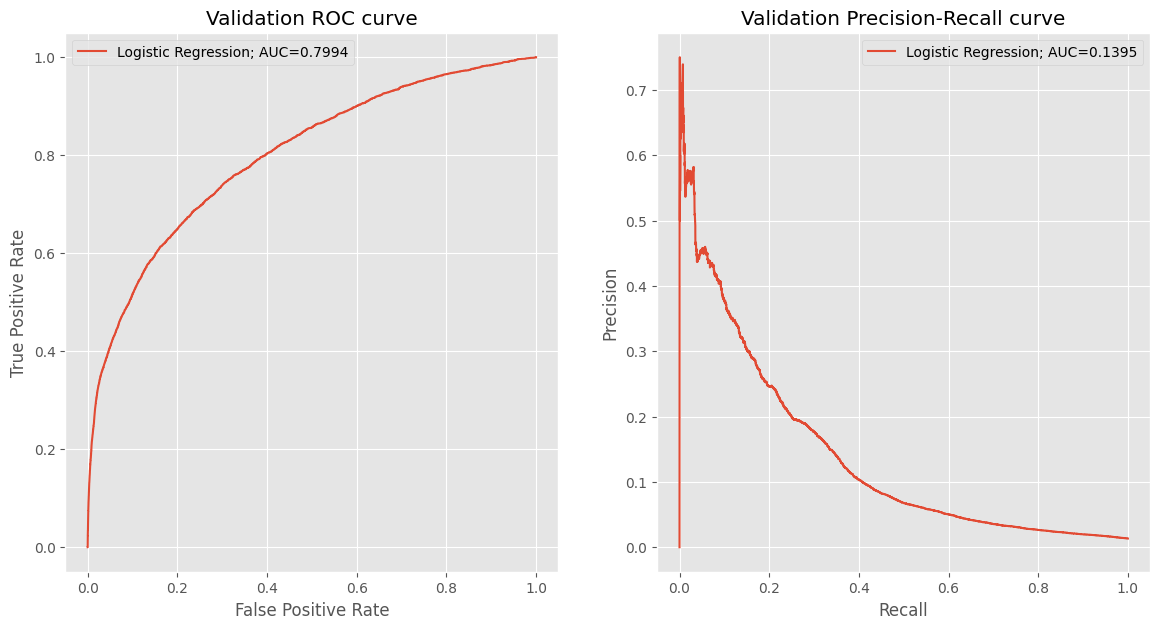

In [22]:
roc, auc_roc, precision_recall, auc_precrec = calculate_metrics(Y_prob_lr, Y_validation)
plot_metrics('Logistic Regression', roc, auc_roc, precision_recall, auc_precrec)

- In this case, since the problem is so balanced with 99% of samples having a value of 0, the ROC curve does not give us as much information as the Precision-Recall.
- Based on this last curve, the goal is to work with the most precision and the most recall as posible. However, in this problem, I consider the recall to be the most important variable, since it is better to have more FP, which will only result in an unnecessary notification, than more FN, which will cause the company to lose possible user purchases.
- Although we could go to high recall values, we see that from 0.3 onwards, the precision drops a lot, which makes raising the recall pointless. Therefore, I think the interesting section of the curve is between 0.25 and 0.3 recall where the precision does not go down, and the recall goes up.

In [23]:
precision_recall[(precision_recall['Recall'] >= 0.25) & (precision_recall['Recall'] <= 0.28)]

,Precision,Recall,Threshold
124412,0.189185,0.279982,0.041681
124413,0.189214,0.279982,0.041708
124414,0.189091,0.279759,0.041713
124415,0.189120,0.279759,0.041723
124416,0.189148,0.279759,0.041735
...,...,...,...
125293,0.200321,0.250111,0.095308
125294,0.200357,0.250111,0.095313
125295,0.200393,0.250111,0.095348
125296,0.200429,0.250111,0.095406


#### FOR THE RECALL OF 0.28 AND PRECISION OF 0.19 IS THE BEST RATIO TO WORK IN THIS PROBLEM AS EXPLAIN BEFORE. THEN, THE THRESHOLD MUST BE AROUND 0.04

In [24]:
threshold = 0.04
Y_pred = np.zeros(Y_prob_lr.shape)
Y_pred[Y_prob_lr > threshold] = 1

In [25]:
C = metrics.confusion_matrix(Y_validation, Y_pred, normalize='true')

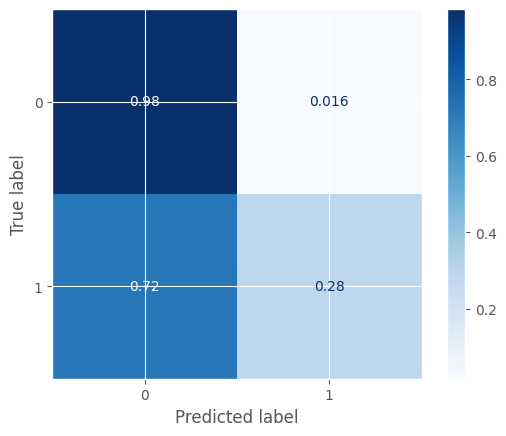

In [26]:
disp = metrics.ConfusionMatrixDisplay(C)
disp.plot(cmap = plt.cm.Blues)
plt.show()

##### WE OBTAIN TP/P = 0.28 (RECALL) AND TN/N = 0.98

### RIDGE

Probamos con diferentes coeficientes de regularización (alpha) para ver qué modelo ofrece mejores metricas.

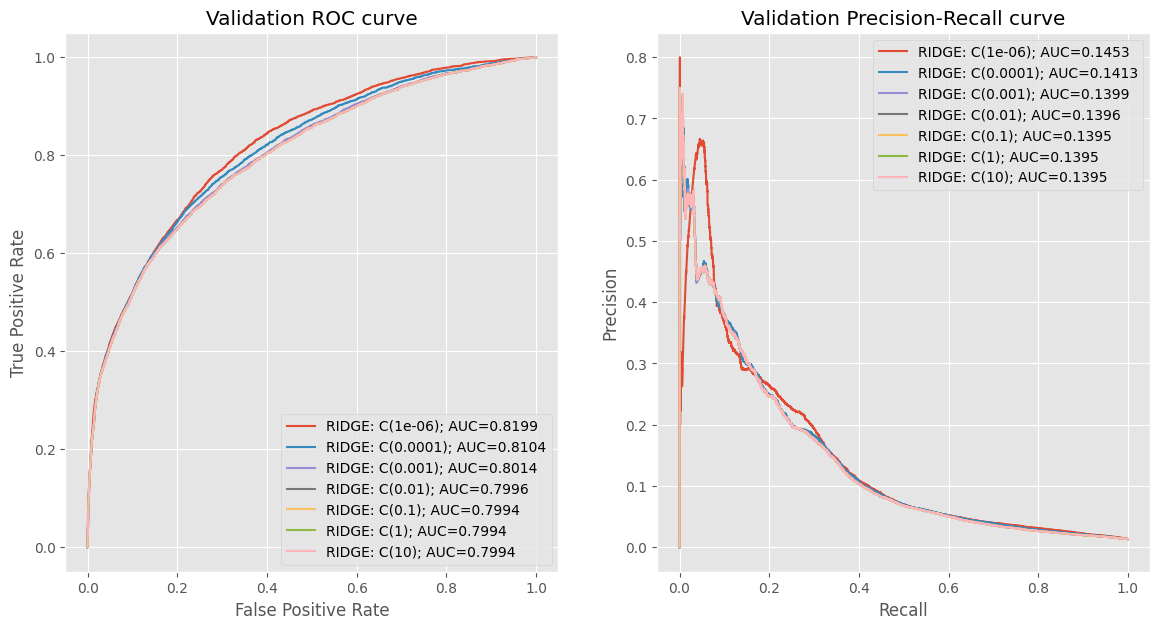

In [27]:
# Definir una lista de valores de C (inverso de alpha) que deseas probar
values_C = [1e-6, 0.0001, 0.001, 0.01, 0.1, 1, 10]

fig, ax = plt.subplots(1, 2, figsize = (14,7))

for alpha in values_C:
    model =  Pipeline([
        ('Freq_Encoding', preprocessor), ('Scaler', StandardScaler()), 
        ('regr', linear_model.LogisticRegression(penalty='l2', C = alpha, max_iter=250, solver='lbfgs'))
    ])
    model.fit(X_train[train_columns], Y_train)
    Y_prob = model.predict_proba(X_validation)[:,1]
    roc, auc_roc, precision_recall, auc_precrec = calculate_metrics(Y_prob, Y_validation)
    plot_metrics(f"RIDGE: C({alpha})", roc, auc_roc, precision_recall, auc_precrec, figure=(fig,ax))

In [28]:
alpha_opt_ridge = 1e-6

We can see that with more regularization (minor C values), the model gets a bit better in some points. Specifically at the operating point chosen in linear regression (about 0.3 recall). 

However, they are not big differences, so in this case, there is no visible overfitting coming from the variables (degrees of freedom), given that the size of the dataset is large, and it reduces the variability of the model.

In [29]:
ridge = Pipeline([
        ('Freq_Encoding', preprocessor), ('Scaler', StandardScaler()), 
        ('regr', linear_model.LogisticRegression(penalty='l2', C = alpha_opt_ridge, max_iter=250, solver='lbfgs'))
    ])
ridge.fit(X_train[train_columns], Y_train)

Pipeline(steps=[('Freq_Encoding',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['user_order_seq',
                                                   'normalised_price',
                                                   'discount_pct',
                                                   'global_popularity',
                                                   'count_adults',
                                                   'count_children',
                                                   'count_babies', 'count_pets',
                                                   'people_ex_baby',
                                                   'days_since_purchase_variant_id',
                                                   'avg_days_to_buy_variant_id',
                                                   'std_days_to_buy_variant_id',
                                                   'days_since_purcha...
                                                   'avg_days_to_buy_product_type',
                                                   'std_days_to_buy_product_type']),
                                                 ('binary', 'passthrough',
                                                  ['ordered_before',
                                                   'abandoned_before',
                                                   'active_snoozed',
                                                   'set_as_regular']),
                                                 ('categorical',
                                                  FunctionTransformer(func=<function calculate_frequency at 0x7f93ca14ccc0>),
                                                  ['product_type',
                                                   'vendor'])])),
                ('Scaler', StandardScaler()),
                ('regr', LogisticRegression(C=1e-06, max_iter=250))])

In [30]:
# Threshold for that recall of around 0.3
Y_prob_ridge = ridge.predict_proba(X_validation)[:,1]
_, _, precision_recall_ridge, _ = calculate_metrics(Y_prob_ridge, Y_validation)
threshold_ridge = round(np.mean(precision_recall_ridge['Threshold'][(precision_recall_ridge['Recall'] >= 0.25) & (precision_recall_ridge['Recall'] <= 0.28)]), 4)

In [31]:
betas_ridge = np.array(ridge.named_steps['regr'].coef_[0])

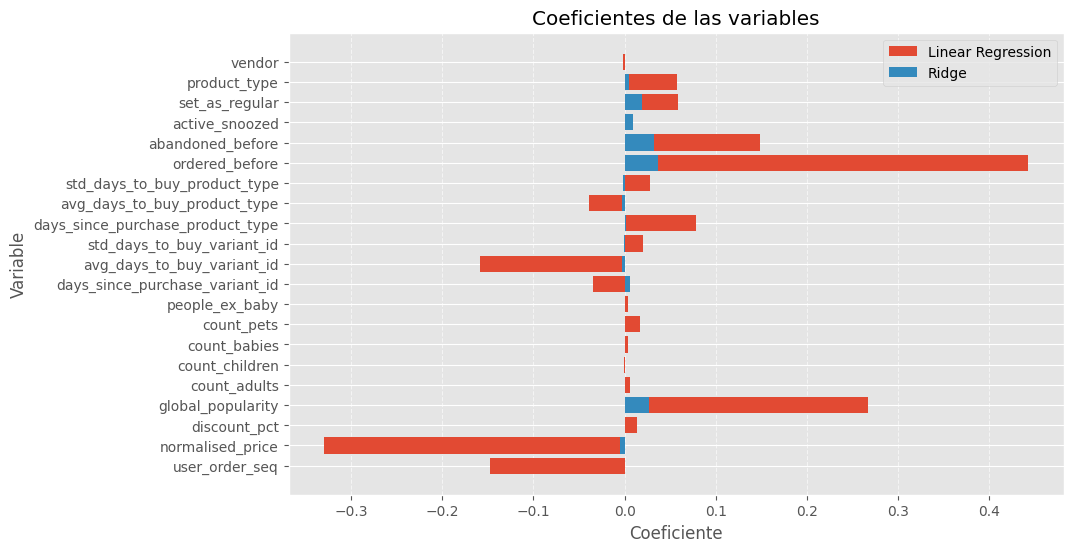

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_betas(model='Linear Regression', columns=train_columns, betas=betas_lr, figure=(fig, ax))
plot_betas(model='Ridge', columns=train_columns, betas=betas_ridge, figure=(fig, ax))

We can check the effect of ridge regularization, where the value of the coefficients of the variables is clearly decreased

In [33]:
Y_pred_ridge = np.zeros(Y_prob_ridge.shape)
Y_pred_ridge[Y_prob_ridge > threshold_ridge] = 1

In [34]:
C_ridge = metrics.confusion_matrix(Y_validation, Y_pred_ridge, normalize='true')

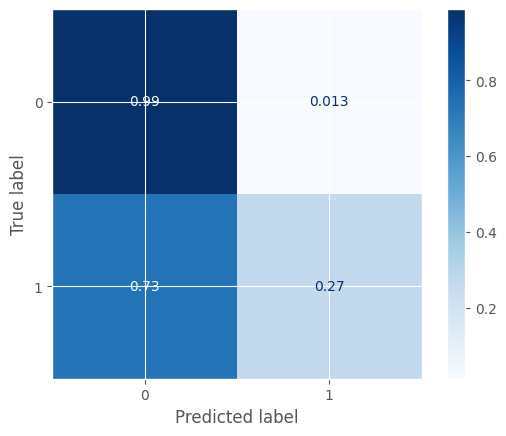

In [35]:
disp = metrics.ConfusionMatrixDisplay(C_ridge)
disp.plot(cmap = plt.cm.Blues)
plt.show()

## LASSO

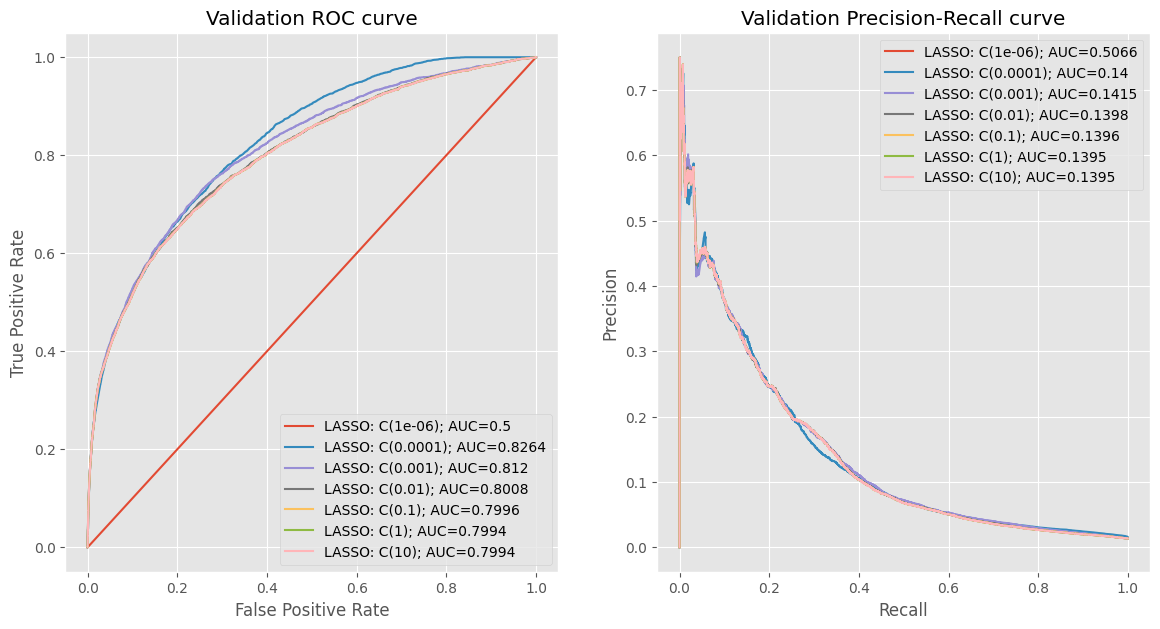

In [36]:
# Definir una lista de valores de C (inverso de alpha) que deseas probar
values_C = [1e-6, 0.0001, 0.001, 0.01, 0.1, 1, 10]

fig, ax = plt.subplots(1, 2, figsize = (14,7))

for alpha in values_C:
    model =  Pipeline([
        ('Freq_Encoding', preprocessor), ('Scaler', StandardScaler()), 
        ('regr', linear_model.LogisticRegression(penalty='l1', C = alpha, max_iter=250, solver='saga'))
    ])
    model.fit(X_train[train_columns], Y_train)
    Y_prob = model.predict_proba(X_validation)[:,1]
    roc, auc_roc, precision_recall, auc_precrec = calculate_metrics(Y_prob, Y_validation)
    plot_metrics(f"LASSO: C({alpha})", roc, auc_roc, precision_recall, auc_precrec, figure=(fig,ax))
    

In the case of lasso, we can observe that a large regularization breaks the model, making it completely random (AUC of 0.5). 

Furthermore, although the regularization of C=0.0001 seems to be the best in the ROC curve, in the precision-recall, in the work zone defined above, the results are worse than other regularizations. 

That is why the optimal one is C=0.001, where it is seen that it has the best ROC and in precision-recall it presents the same characteristics as the other values of C. 

In addition, it must be taken into account that lasso takes the beta values to zero with high regularization, so it is better to take low C in this case to reduce the computational load of the model in real time.

In [37]:
alpha_opt_lasso = 0.001

In [38]:
lasso = Pipeline([
        ('Freq_Encoding', preprocessor), ('Scaler', StandardScaler()), 
        ('regr', linear_model.LogisticRegression(penalty='l1', C = alpha_opt_lasso,
        max_iter=250, solver='saga'))
    ])
lasso.fit(X_train[train_columns], Y_train)

Pipeline(steps=[('Freq_Encoding',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['user_order_seq',
                                                   'normalised_price',
                                                   'discount_pct',
                                                   'global_popularity',
                                                   'count_adults',
                                                   'count_children',
                                                   'count_babies', 'count_pets',
                                                   'people_ex_baby',
                                                   'days_since_purchase_variant_id',
                                                   'avg_days_to_buy_variant_id',
                                                   'std_days_to_buy_variant_id',
                                                   'days_since_purcha...
                                                   'std_days_to_buy_product_type']),
                                                 ('binary', 'passthrough',
                                                  ['ordered_before',
                                                   'abandoned_before',
                                                   'active_snoozed',
                                                   'set_as_regular']),
                                                 ('categorical',
                                                  FunctionTransformer(func=<function calculate_frequency at 0x7f93ca14ccc0>),
                                                  ['product_type',
                                                   'vendor'])])),
                ('Scaler', StandardScaler()),
                ('regr',
                 LogisticRegression(C=0.001, max_iter=250, penalty='l1',
                                    solver='saga'))])

In [39]:
# Threshold for that recall of around 0.3
Y_prob_lasso = lasso.predict_proba(X_validation)[:,1]
_, _, precision_recall_lasso, _ = calculate_metrics(Y_prob_lasso, Y_validation)
threshold_lasso = round(np.mean(precision_recall_lasso['Threshold'][(precision_recall_lasso['Recall'] >= 0.25) & (precision_recall_lasso['Recall'] <= 0.28)]), 4)

In [40]:
betas_lasso = np.array(lasso.named_steps['regr'].coef_[0])

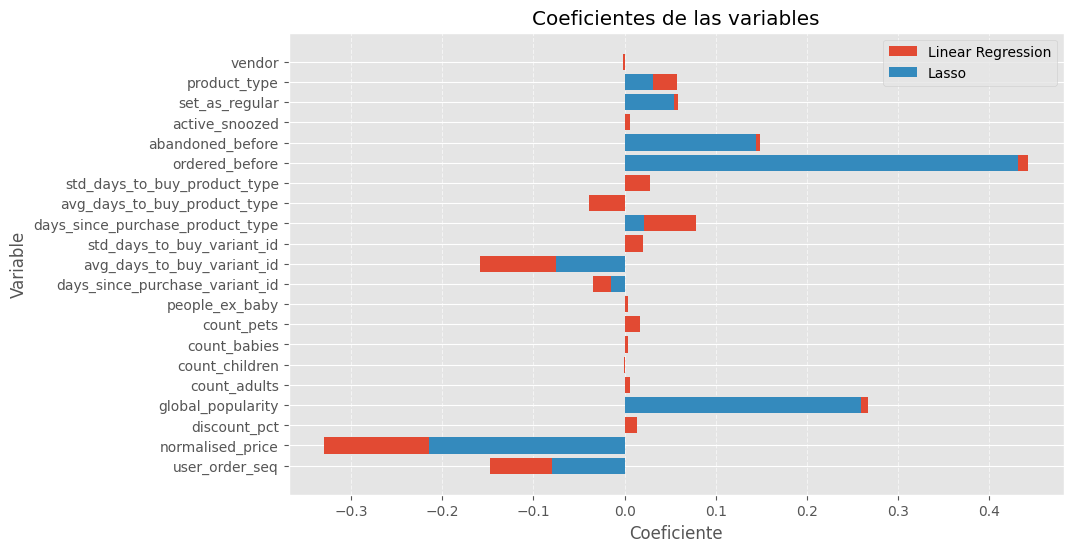

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_betas(model='Linear Regression', columns=train_columns, betas=betas_lr, figure=(fig, ax))
plot_betas(model='Lasso', columns=train_columns, betas=betas_lasso, figure=(fig, ax))

The lasso effect can be clearly observed. The most important variables maintain their coefficient values, while the less important ones (low betas in the model without regularization) become 0.

In fact, 5 coefficients (abandoned_before, ordered_before, global_popularity, user_order_seq, normalised_price) are clearly the most important, so it can be estimated that they are the ones that most help predict the response.

In [42]:
Y_pred_lasso = np.zeros(Y_prob_lasso.shape)
Y_pred_lasso[Y_prob_lasso > threshold_lasso] = 1

In [43]:
C_lasso = metrics.confusion_matrix(Y_validation, Y_pred_lasso, normalize='true')

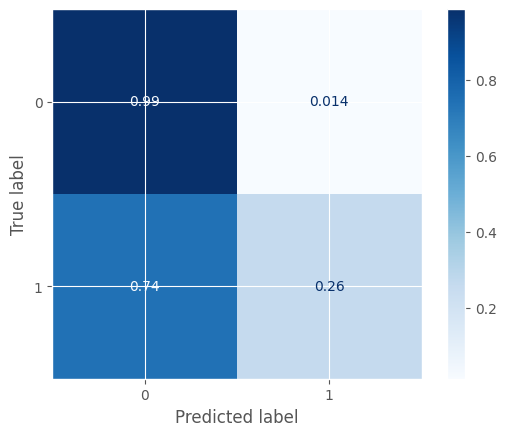

In [44]:
disp = metrics.ConfusionMatrixDisplay(C_lasso)
disp.plot(cmap = plt.cm.Blues)
plt.show()

### COMPARING THE 3 MODELS

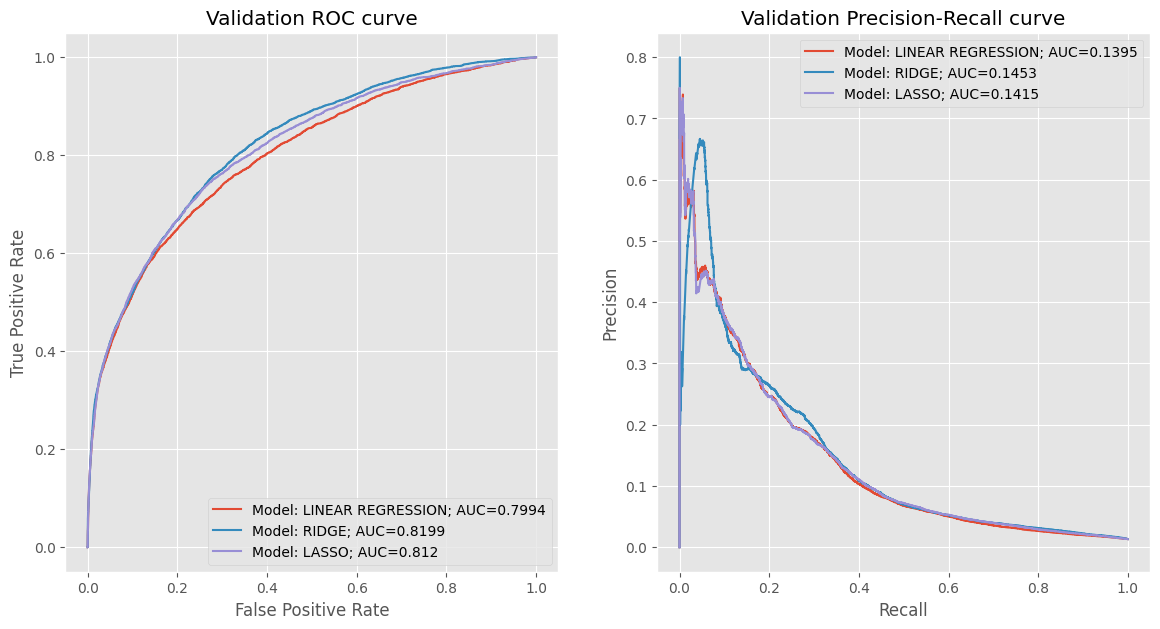

In [45]:
fig, ax = plt.subplots(1, 2, figsize = (14,7))

models_prob = [Y_prob_lr, Y_prob_ridge, Y_prob_lasso]
model_names = ['LINEAR REGRESSION', 'RIDGE', 'LASSO']

for prob, model_name in zip(models_prob, model_names):
    roc, auc_roc, precision_recall, auc_precrec = calculate_metrics(prob, Y_validation)
    plot_metrics(f"Model: {model_name}", roc, auc_roc, precision_recall, auc_precrec, figure=(fig,ax))

### INSIGHTS:
- The results are very similar in the 3 models. The decided work point for recall is of 0.28 which means that out of all positives the model will predict 28% of them. This is a boost of 28% over
the selected items, which was one of the targets of the problem.
- Since the dataset is large, the regularization doesn't affect, because the overfitting is not a real problem.
- Although the ridge model offers a minimal improvement in precision recall, I think the best choice is lasso, because there are a few variables (explained before) that have impact over the prediction. Because of that, and since the lasso model gets rid of some variables getting their betas to 0, the model will be lighter and will have less computational load

We decided that Lasso was the most optimal in this case. However, in the graphics where the coefficients are painted, only 5 of them have clearly big relation with the response compared with other. So the final model will only use this 5 variables so that we can avoid some variables like the categorical ones, that they consume computacional resources during the training and predicting phase.

In [52]:
selected_columns = ['abandoned_before', 'ordered_before', 'global_popularity', 'user_order_seq', 'normalised_price']

final_model = Pipeline([
        ('Scaler', StandardScaler()), 
        ('regr', linear_model.LogisticRegression(penalty=None, max_iter=250, solver='lbfgs'))
    ])
final_model.fit(X_train[selected_columns], Y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('regr', LogisticRegression(max_iter=250, penalty=None))])

In [53]:
Y_prob_final = final_model.predict_proba(X_validation[selected_columns])[:,1]

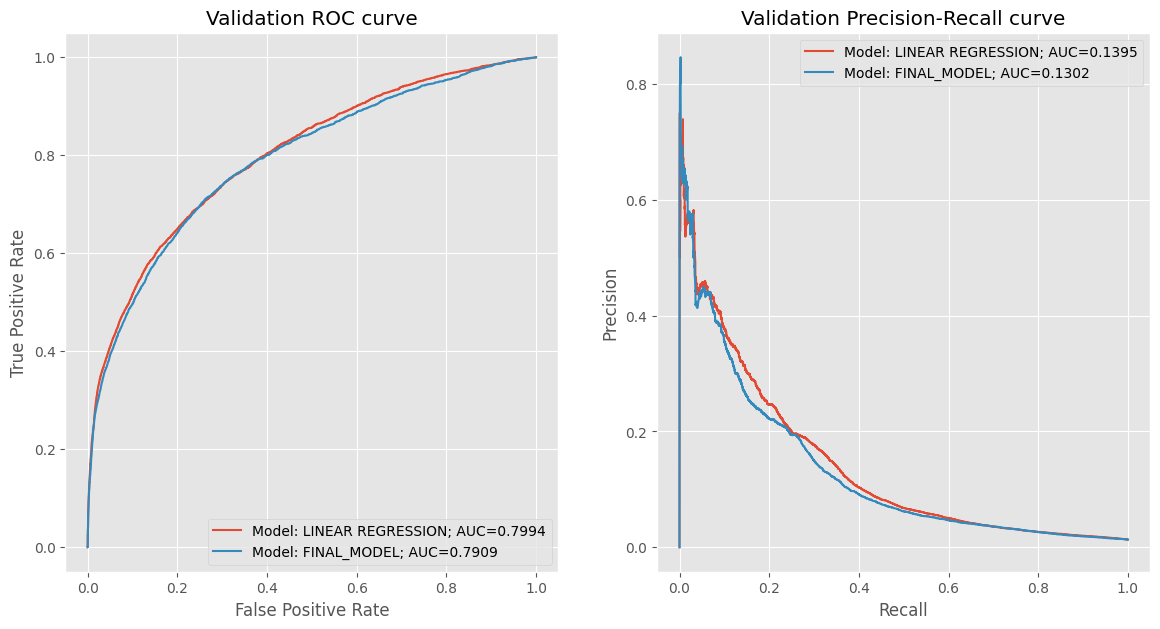

In [55]:
fig, ax = plt.subplots(1, 2, figsize = (14,7))

models_prob = [Y_prob_lr, Y_prob_final]
model_names = ['LINEAR REGRESSION', 'FINAL_MODEL']

for prob, model_name in zip(models_prob, model_names):
    roc, auc_roc, precision_recall, auc_precrec = calculate_metrics(prob, Y_validation)
    plot_metrics(f"Model: {model_name}", roc, auc_roc, precision_recall, auc_precrec, figure=(fig,ax))

We can see that they are very similar, specifically, in the work point of aroung 0.28 of recall. So the other variables are unnecessary in this case.

Now that we have the final model, we are going to predict tha values with the testing dataset, in order to see if the validation results are contrasted and we didn't made a manual overfitting.

In [56]:
Y_prob_test_final = final_model.predict_proba(X_test[selected_columns])[:,1]

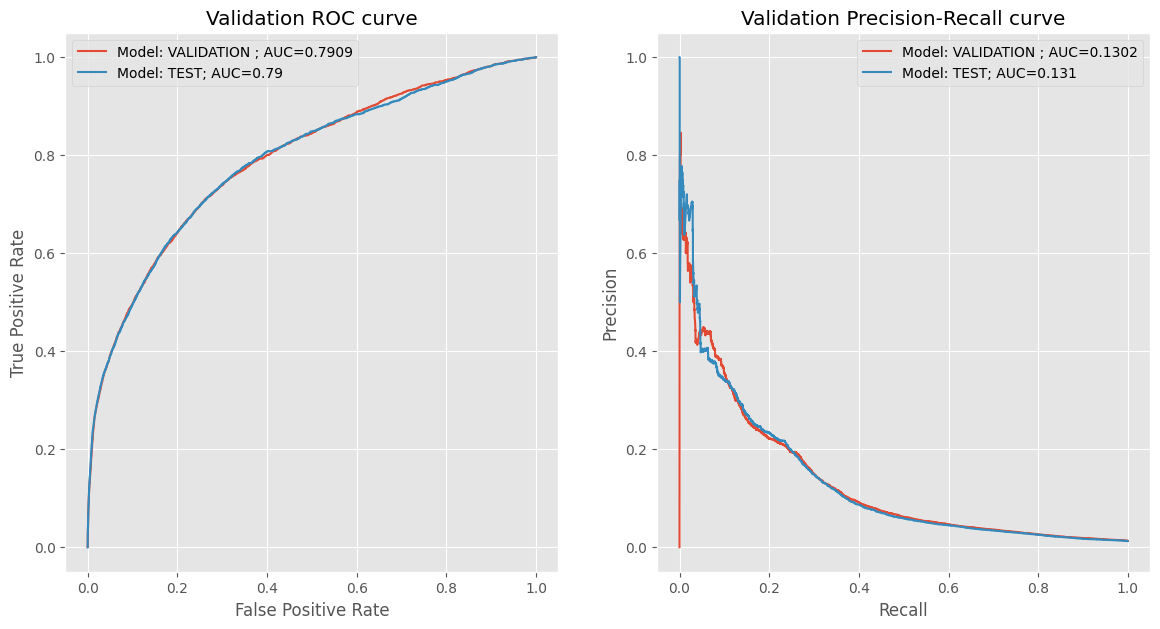

In [58]:
fig, ax = plt.subplots(1, 2, figsize = (14,7))

roc, auc_roc, precision_recall, auc_precrec = calculate_metrics(Y_prob_final, Y_validation)
plot_metrics(f"Model: VALIDATION ", roc, auc_roc, precision_recall, auc_precrec, figure=(fig,ax))
roc, auc_roc, precision_recall, auc_precrec = calculate_metrics(Y_prob_test_final, Y_test)
plot_metrics(f"Model: TEST", roc, auc_roc, precision_recall, auc_precrec, figure=(fig,ax))

## We confirm the results 